In [2]:
# ==== VIS SETUP ====
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
REPORTS = Path("reports"); REPORTS.mkdir(parents=True, exist_ok=True)

# Load the classified data and (optionally) embeddings + index
df = pd.read_parquet("data/shows_classified.parquet")
X = np.load("vectors/summaries.npy")  # optional, for 2D plots
idx = pd.read_parquet("vectors/summaries_index.parquet")  # id + name

print("Rows:", len(df), "| Columns:", list(df.columns))

Rows: 485 | Columns: ['id', 'name', 'genres', 'summary_html', 'language', 'status', 'officialSite', 'premiered', 'rating', 'network', 'webChannel', 'original_summary', 'ai_summary', 'pred_category']


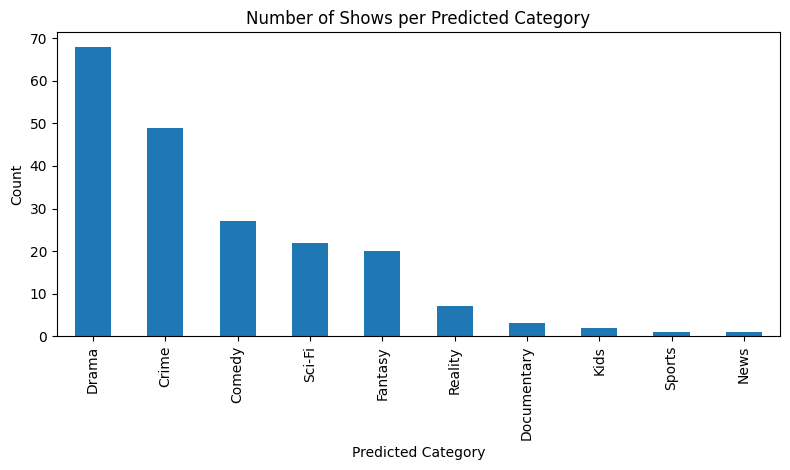

Saved: reports\cat_counts_bar.png


In [4]:
# ==== CATEGORY COUNTS BAR ====
counts = df["pred_category"].value_counts().sort_values(ascending=False)

plt.figure(figsize=(8, 4.8))
counts.plot(kind="bar")
plt.title("Number of Shows per Predicted Category")
plt.xlabel("Predicted Category")
plt.ylabel("Count")
plt.tight_layout()
out = REPORTS / "cat_counts_bar.png"
plt.savefig(out, dpi=200)
plt.show()
print("Saved:", out)

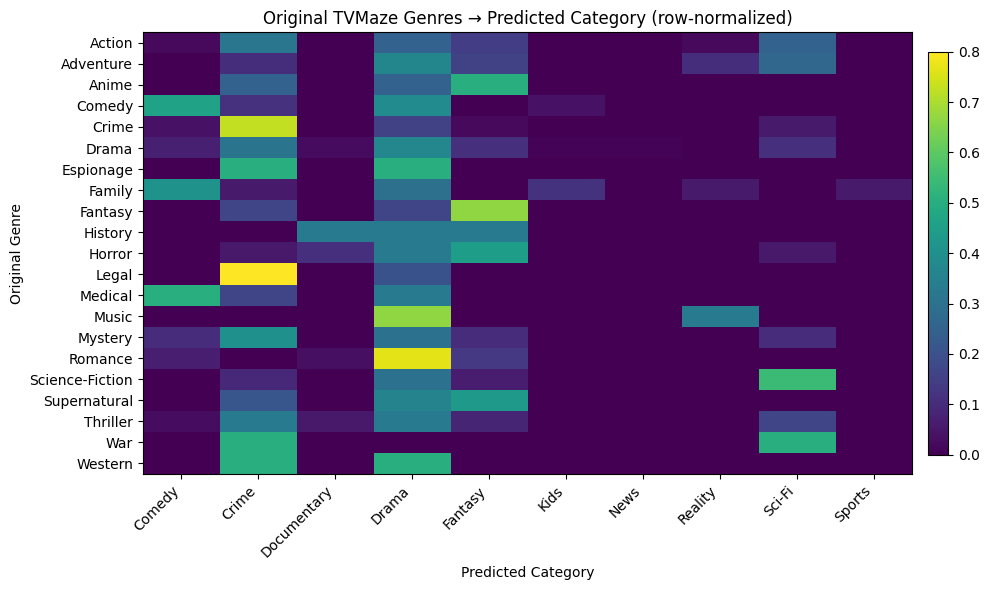

Saved: reports\genres_vs_category_heatmap.png


In [6]:
# ==== GENRES vs PRED_CATEGORY HEATMAP ====
# Explode 'genres' (list) to rows, then crosstab
df_exp = df.explode("genres")
ct = pd.crosstab(df_exp["genres"], df_exp["pred_category"]).sort_index()

plt.figure(figsize=(10, 6))
# Normalize rows so it’s easy to compare across genres
data = ct.div(ct.sum(axis=1).replace(0, np.nan), axis=0).fillna(0).values

im = plt.imshow(data, aspect="auto")
plt.colorbar(im, fraction=0.025, pad=0.02)
plt.yticks(range(len(ct.index)), ct.index)
plt.xticks(range(len(ct.columns)), ct.columns, rotation=45, ha="right")
plt.title("Original TVMaze Genres → Predicted Category (row-normalized)")
plt.xlabel("Predicted Category")
plt.ylabel("Original Genre")
plt.tight_layout()
out = REPORTS / "genres_vs_category_heatmap.png"
plt.savefig(out, dpi=200)
plt.show()
print("Saved:", out)

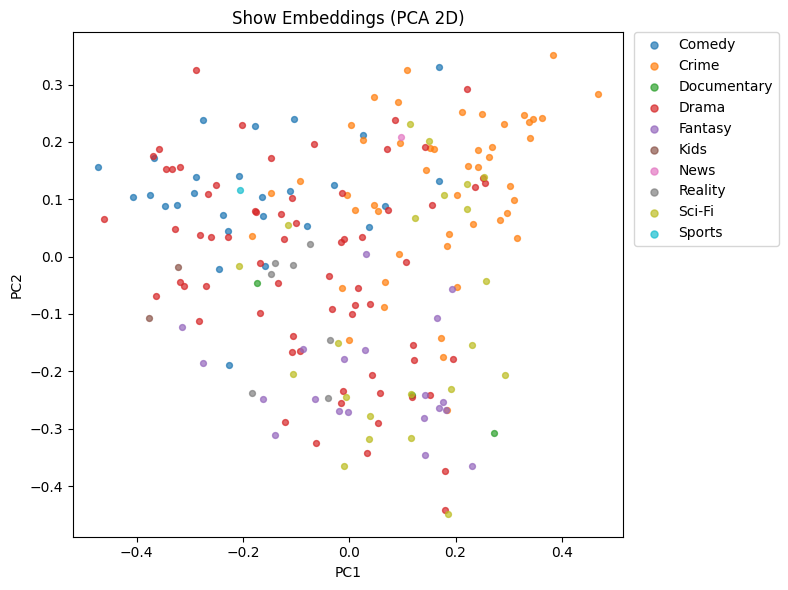

Saved: reports\pca_scatter_by_category.png


In [7]:
# ==== PCA 2D SCATTER ====
from sklearn.decomposition import PCA

# Align embeddings X to the classified rows (idx has the same order used for X)
df_embed = pd.merge(idx, df[["id", "pred_category"]], on="id", how="left")

pca = PCA(n_components=2, random_state=7)
Z = pca.fit_transform(X)  # shape: (n, 2)

plt.figure(figsize=(8, 6))
cats = df_embed["pred_category"].fillna("Unlabeled").values
uniq = sorted(pd.unique(cats))

# simple legend: one color per category
for c in uniq:
    mask = (cats == c)
    plt.scatter(Z[mask, 0], Z[mask, 1], s=18, alpha=0.7, label=c)

plt.title("Show Embeddings (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(markerscale=1.2, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)
plt.tight_layout()
out = REPORTS / "pca_scatter_by_category.png"
plt.savefig(out, dpi=200)
plt.show()
print("Saved:", out)

In [9]:
# ==== SAMPLE ROWS PER CATEGORY ====
def sample_rows_per_category(frame, k=3):
    parts = []
    for cat in sorted(frame["pred_category"].dropna().unique()):
        subset = frame[frame["pred_category"] == cat].head(k)
        parts.append(subset[["name", "genres", "ai_summary"]])
    return pd.concat(parts, axis=0)

preview = sample_rows_per_category(df, k=2)
print(preview.to_string(index=False))
# Optionally export a pretty CSV to drop into slides
preview.to_csv(REPORTS / "samples_per_category.csv", index=False)
print("Saved:", REPORTS / "samples_per_category.csv")

                  name                               genres                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            ai_summary
                 Fargo               [Drama, Comedy, Crime]                                                                                                                                                                            In the darkly comedic anthology series **Fargo**, each season unveils a new crime story, rich with mysterious characters and unexpected twists. Set against the backdrop of the icy Midwest, th

c:\Users\brethm01\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


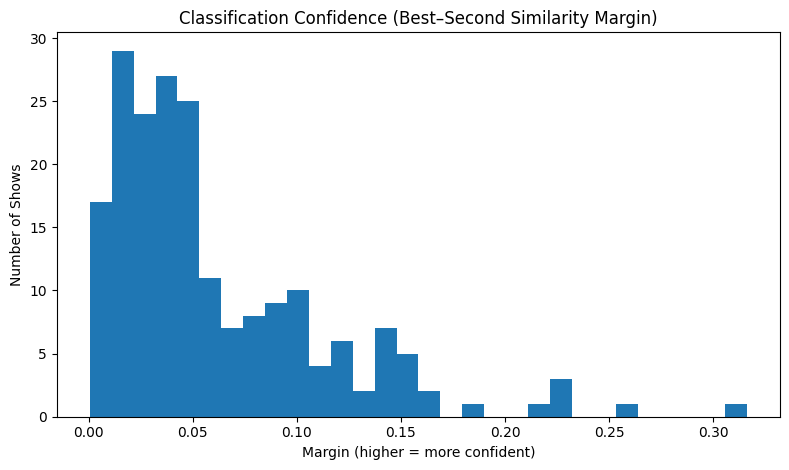

Saved: reports\confidence_margin_hist.png


In [10]:
# ==== CONFIDENCE PROXY (MARGIN) ====
# Recompute category embeddings & similarities (fast)
from sentence_transformers import SentenceTransformer

MODEL_NAME = "all-MiniLM-L6-v2"
CATEGORIES = {
    "Drama": "Serious, character-driven stories and emotional conflicts.",
    "Comedy": "Lighthearted, humorous stories designed to make viewers laugh.",
    "Sci-Fi": "Futuristic technology, space, or speculative science.",
    "Fantasy": "Magic, mythical creatures, or imaginary worlds.",
    "Crime": "Police work, criminals, investigations, or legal drama.",
    "Reality": "Unscripted or competition-based programmes featuring real people.",
    "Documentary": "Non-fiction programmes educating about real events or topics.",
    "Kids": "Content primarily designed for children or families.",
    "News": "Current events, daily news, analysis, or interviews.",
    "Sports": "Live sports, analysis, or athletic competitions."
}

model = SentenceTransformer(MODEL_NAME)
cat_texts = [f"{k}: {v}" for k, v in CATEGORIES.items()]
cat_vecs = model.encode(cat_texts, convert_to_numpy=True, normalize_embeddings=True).astype(np.float32)

S = X @ cat_vecs.T  # (n_shows, n_cats) cosine sims since normalized
sorted_idx = np.argsort(-S, axis=1)  # descending
best = S[np.arange(S.shape[0]), sorted_idx[:, 0]]
second = S[np.arange(S.shape[0]), sorted_idx[:, 1]]
margin = best - second

plt.figure(figsize=(8, 4.8))
plt.hist(margin, bins=30)
plt.title("Classification Confidence (Best–Second Similarity Margin)")
plt.xlabel("Margin (higher = more confident)")
plt.ylabel("Number of Shows")
plt.tight_layout()
out = REPORTS / "confidence_margin_hist.png"
plt.savefig(out, dpi=200)
plt.show()
print("Saved:", out)